In [2]:
!pip install easyocr -q

     |████████████████████████████████| 2.9 MB 10.1 MB/s 
     |████████████████████████████████| 604 kB 50.2 MB/s 
     |████████████████████████████████| 47.6 MB 115 kB/s 
     |████████████████████████████████| 108 kB 61.4 MB/s 


In [3]:
# imports

import numpy as np
import cv2
import easyocr
import cv2
from matplotlib import pyplot as plt
import imutils
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# A Sample class with init method
class Car:

  # init method or constructor
  def __init__(self):
      pass

  def __filters(self, img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
    edged = cv2.Canny(bfilter, 30, 200) #Edge detection
    return gray, bfilter, edged
  
  def __search_plate_and_crop(self, img, edged, gray):
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    
    location = 0
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)
        if len(approx) == 4:
            location = approx
            break
    mask = np.zeros(gray.shape, np.uint8)
    new_image = cv2.drawContours(mask, [location], 0,255, -1)
    new_image = cv2.bitwise_and(img, img, mask=mask)

    (x,y) = np.where(mask==255)
    (x1, y1) = (np.min(x), np.min(y))
    (x2, y2) = (np.max(x), np.max(y))
    cropped_image = gray[x1:x2+1, y1:y2+1]
    return new_image, approx, cropped_image

  def __create_new_folder(self, path, folder_name): 
    try: 
      current_path = os.getcwd() 
      os.chdir('.')
      path = os.getcwd()
      full_path = os.path.join(path, folder_name) 
      os.makedirs(full_path) 
      os.chdir(current_path)
      return full_path
    except OSError as error: 
      print(f"Already have a folder called: {folder_name} in this directory")
      full_path = os.path.join(path, folder_name)
      return full_path 

  def __plot_images(self, img1, img2, title1="", title2=""):
    fig = plt.figure(figsize=[15,15])
    ax1 = fig.add_subplot(121)
    ax1.imshow(img1, cmap="gray")
    ax1.set(xticks=[], yticks=[], title=title1)

    ax2 = fig.add_subplot(122)
    ax2.imshow(img2, cmap="gray")
    ax2.set(xticks=[], yticks=[], title=title2)
    
    return fig

  # Sample Method
  def plateDetection(self, path, folder_name, show_steps = False):
    self.path = path
    self.folder_name = folder_name
    df_lista = []

    full_path = self.__create_new_folder(path, folder_name)

    for dir, subarch, archives in os.walk(path):
      for path_imagem in archives:
        try:
          img = cv2.imread(path + "/" + str(path_imagem))
          gray, bfilter, edged  = self.__filters(img)
          new_image, approx, cropped_image = self.__search_plate_and_crop(img, edged, gray)

          reader = easyocr.Reader(['en'])
          result = reader.readtext(cropped_image)

          text = result[0][-2]
          df_lista.append((path_imagem, text))
          font = cv2.FONT_HERSHEY_SIMPLEX
          res = cv2.putText(img, text=text, org=(approx[1][0][0], approx[2][0][1]+30), fontFace=font, fontScale=0.7, color=(0,255,0), thickness=3, lineType=cv2.LINE_AA)
          res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
          plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
          plt.savefig(full_path + "/" + path_imagem)
        except IndexError as IE:
          print(f"\n\nOcorreu um erro de Index na imagem: {path_imagem}, porém continuando para a proxima imagem")
          continue
        except Exception as error:
          print(f"\n\nOcorreu um erro na imagem: {path_imagem}, porém continuando para a proxima imagem")
          continue

    df_aux = pd.DataFrame(df_lista)
    df_aux.rename(columns={0: "Image", 1: "Plate"}, inplace = True)
    df = df_aux.sort_values("Image").to_csv(full_path + "/" + "results.csv", index = False)

    if show_steps == True:
      self.__plot_images(img, gray, title1="original", title2="gray")
      self.__plot_images(gray, bfilter, title1="gray", title2="bfilter")
      self.__plot_images(bfilter, edged, title1="bfilter", title2="edged")
      self.__plot_images(img, cropped_image, title1="original", title2="cropped_image")

    return df
    
  def YOLOplateDetection(self, path, folder_name):
    self.path = path
    self.folder_name = folder_name
    df_lista_yolo = []

    full_path = self.__create_new_folder(path, folder_name)

    for dir, subarch, archives in os.walk(path):
      for path_imagem in archives:
        try:
          img = cv2.imread(path + "/" + str(path_imagem))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          reader = easyocr.Reader(['en'])
          result = reader.readtext(img)
          text = result[0][-2]
          df_lista_yolo.append((path_imagem, text))

        except IndexError as IE:
          print(f"\n\nOcorreu um erro de Index na imagem: {path_imagem}, porém continuando para a proxima imagem")
          continue
        except Exception as error:
          print(f"\n\nOcorreu um erro na imagem: {path_imagem}, porém continuando para a proxima imagem")
          continue

    df_aux = pd.DataFrame(df_lista_yolo)
    df_aux.rename(columns={0: "Image", 1: "Plate"}, inplace = True)
    df = df_aux.sort_values("Image").to_csv(full_path + "/" + "yolo_results.csv", index = False)

    return df

# To run the class above, do:

# Car().plateDetection(path = "/content/samples", folder_name = "detection", show_steps = True) -- example

### Yolo

In [ ]:
!unzip /content/drive/MyDrive/datasets/car_plate/detected_images_all.zip -d /content/yolo_detection

In [5]:
Car().YOLOplateDetection(path = "/content/yolo_detection/content/yolov5/runs/detect/exp8/crops/license", folder_name = "detection")

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Ocorreu um erro de Index na imagem: Cars106.jpg, porém continuando para a proxima imagem


Ocorreu um erro de Index na imagem: Cars277.jpg, porém continuando para a proxima imagem


Ocorreu um erro de Index na imagem: Cars383.jpg, porém continuando para a proxima imagem


Ocorreu um erro de Index na imagem: Cars472.jpg, porém continuando para a proxima imagem


Ocorreu um erro de Index na imagem: Cars295.jpg, porém continuando para a proxima imagem


Ocorreu um erro de Index na imagem: Cars1062.jpg, porém continuando para a proxima imagem


Ocorreu um erro de Index na imagem: Cars1463.jpg, porém continuando para a proxima imagem


Ocorreu um erro de Index na imagem: Cars3902.jpg, porém continuando para a proxima imagem


Ocorreu um erro de Index na imagem: Cars2773.jpg, porém continuando para a proxima imagem


Ocorreu um erro de Index na imagem: Cars421.jpg, porém continuando para a proxima imagem


Ocorre

In [6]:
df_yolo = pd.read_csv("/content/detection/yolo_results.csv")
df_yolo.shape

(368, 2)

In [9]:
df_yolo.head()

,Image,Plate
0,Cars0.jpg,KLO1CA2555
1,Cars1.jpg,PGoMN12
2,Cars10.jpg,TN
3,Cars100.jpg,Jaf Jssm
4,Cars101.jpg,HR 26 BC 5514


### Classic

In [ ]:
!unzip /content/drive/MyDrive/datasets/car_plate/archive.zip -d /content/dataset



Ocorreu um erro de Index na imagem: Cars382.png, porém continuando para a proxima imagem


Ocorreu um erro de Index na imagem: Cars326.png, porém continuando para a proxima imagem


Ocorreu um erro na imagem: Cars129.png, porém continuando para a proxima imagem


Ocorreu um erro de Index na imagem: Cars388.png, porém continuando para a proxima imagem


Ocorreu um erro na imagem: Cars113.png, porém continuando para a proxima imagem


Ocorreu um erro de Index na imagem: Cars134.png, porém continuando para a proxima imagem


Ocorreu um erro de Index na imagem: Cars156.png, porém continuando para a proxima imagem


Ocorreu um erro na imagem: Cars425.png, porém continuando para a proxima imagem


Ocorreu um erro de Index na imagem: Cars178.png, porém continuando para a proxima imagem


Ocorreu um erro de Index na imagem: Cars349.png, porém continuando para a proxima imagem


Ocorreu um erro de Index na imagem: Cars401.png, porém continuando para a proxima imagem


Ocorreu um erro na image

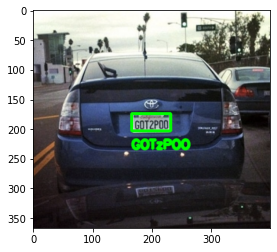

In [17]:
Car().plateDetection(path = "/content/dataset/images", folder_name = "detection_classic", show_steps = False)

In [18]:
df_classic = pd.read_csv("/content/results.csv")
df_classic.shape

(148, 2)

In [19]:
df_classic.head()

,Image,Plate
0,Cars0.png,KL01CA2555
1,Cars1.png,PGoMN112
2,Cars102.png,8
3,Cars109.png,Czi7 kod
4,Cars11.png,COR S16K
